In [1]:
import ROOT
import numpy as np
from array import *
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import colors 
import math
import pandas as pd

In [2]:
def resultsTOtxt(arr,  filename):
#arr is the concatenated and transposed array of all the arrays wished to be written
#arrDescription a string describing and is each collumn of the file
#writes out each array concatenated in arr as an collumn in the file
    file = open(filename, 'w')
    np.savetxt(filename, arr, delimiter=' ')
    file.close()
    
def GetNpArraysFromTrees(tree, branch_name):
    estimate = 3e6 #amount of numbers getting from branch
    tree.SetEstimate(int(estimate))
    result_hist = tree.Draw(branch_name, "", "goff")
    result = np.asarray(np.frombuffer(tree.GetV1(), dtype=np.float64, count=result_hist))
    result = result.copy()
    return result

def GetNpArraysFromTrees2(tree, branch_name):
    estimate = 3e8 #amount of numbers getting from branch
    tree.SetEstimate(int(estimate))
    result_hist = tree.Draw(branch_name, "", "goff")
    result = np.asarray(np.frombuffer(tree.GetV1(), count=result_hist))
    result = result.copy()
    return result

In [3]:
def ReadNuclearModelSamples(IsBDM, massANDboost=None):
    if IsBDM:
        fBDM_00a = ROOT.TFile.Open("/home/leoperes/ntuples_grid_newVertex/00a_newVertex/bdm_"+massANDboost+"_00a.root")
        if massANDboost != 'm20_b10':
            fBDM_01a = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/01a_newVertex/bdm_'+massANDboost+'_01a.root')
        fBDM_02a = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/02a_newVertex/bdm_'+massANDboost+'_02a.root')
        fBDM_00b = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00b_newVertex/bdm_'+massANDboost+'_00b.root')
        fBDM_01b = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/01b_newVertex/bdm_'+massANDboost+'_01b.root')
        fBDM_02b = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/02b_newVertex/bdm_'+massANDboost+'_02b.root')
        if massANDboost != 'm20_b10':
            samples = [fBDM_00a, fBDM_01a, fBDM_02a, fBDM_00b, fBDM_01b, fBDM_02b]
        else:
            samples = [fBDM_00a, fBDM_02a, fBDM_00b, fBDM_01b, fBDM_02b]
        return samples
    if not IsBDM:
        fAtm_00a = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00a_newVertex/atm_hA_BR_4ana.root')
        fAtm_01a = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/01a_newVertex/atm_hA_LFG.root')
        fAtm_02a = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/02a_newVertex/atm_hA_ESF.root')
        fAtm_00b = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00b_newVertex/atm_hN_BR.root')
        fAtm_01b = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/01b_newVertex/atm_hN_LFG.root')
        fAtm_02b = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/02b_newVertex/atm_hN_ESF.root')
        samples = [fAtm_00a, fAtm_01a, fAtm_02a, fAtm_00b, fAtm_01b, fAtm_02b]
        return samples

In [4]:
listsamples = ['m05_b1p1', 'm05_b1p5', 'm05_b10', 'm10_b1p1', 'm10_b1p5', 'm10_b10', 'm20_b1p1', 'm20_b1p5', 'm20_b10', 'm40_b1p1', 'm40_b1p5', 'm40_b10']
list_samples_latex = [r'$m_\chi = 5 \text{ GeV}, \; \gamma=1.1$', r'$m_\chi = 5 \text{ GeV}, \; \gamma=1.5$', r'$m_\chi = 5 \text{ GeV}, \; \gamma=10$', r'$m_\chi = 10 \text{ GeV}, \; \gamma=1.1$', r'$m_\chi = 10 \text{ GeV}, \; \gamma=1.5$', r'$m_\chi = 10 \text{ GeV}, \; \gamma=10$', r'$m_\chi = 20 \text{ GeV}, \; \gamma=1.1$', r'$m_\chi = 20 \text{ GeV}, \; \gamma=1.5$', r'$m_\chi = 20 \text{ GeV}, \; \gamma=10$', r'$m_\chi = 40 \text{ GeV}, \; \gamma=1.1$', r'$m_\chi = 40 \text{ GeV}, \; \gamma=1.5$', r'$m_\chi = 40 \text{ GeV}, \; \gamma=10$' ]
list_nuclearmodels = ['hA_BR','hA_LSF', 'hA_ESF', 'hN_BR', 'hN_LFG', 'hN_ESF']

In [5]:
def vec_mod(arr):
    return math.sqrt(arr[0]**2+arr[1]**2+arr[2]**2)

In [6]:
FluxRotValues = np.array([[+0.9877, -0.1564, +0.0000],  # new x axis in old coordinates: be nice and fix things (ends up the same)
                        [+0.0000, +0.0000, +1.0000],  # new y axis in old coordinates: vertical
                        [-0.1564, -0.9877, +0.0000]])   # new z axis in old coordinates: away from Batavia, IL

Inverse_FluxRotValues = np.linalg.inv(FluxRotValues)

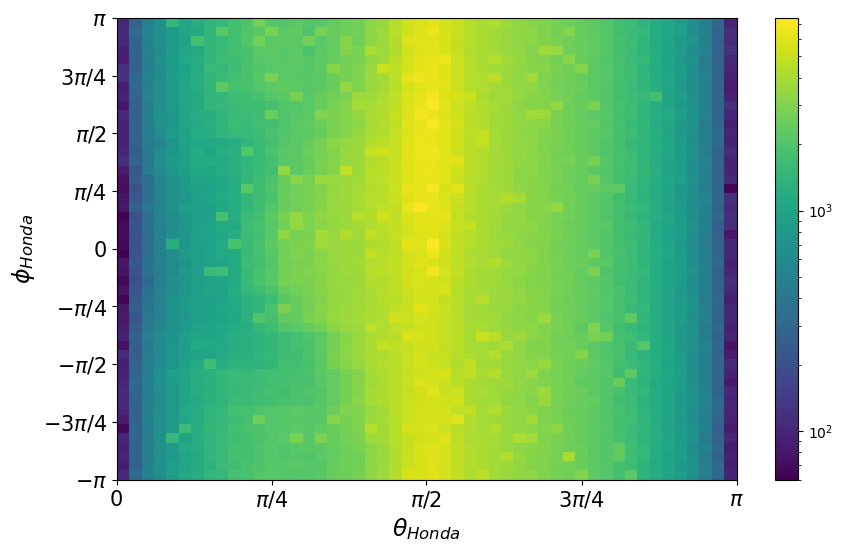

In [9]:

infiles_list = ReadNuclearModelSamples(False)
intrees_reco = [lambda arg=infile: arg.Get("ana/Atm") for infile in infiles_list]
intrees_simu = [lambda arg=infile: arg.Get("ana/AllEvents") for infile in infiles_list]
reco_entries = [intree().GetEntries() for intree in intrees_reco]
    
MCNuMomentum = [GetNpArraysFromTrees2(func(),"MCNuMomentum") for func in intrees_reco]
NuMom_True = [nuclearmodel.reshape(reco_entries[i_sample],3) for i_sample, nuclearmodel in enumerate(MCNuMomentum)]
NuMom_True_Unit = [[Inverse_FluxRotValues.dot(evt/vec_mod(evt)) for evt in nuclearmodel] for nuclearmodel in NuMom_True]
plot_dirdetc_nu = []
Phi_Theta_NuMom_Unit = [[plot_dirdetc_nu.append((math.atan2(nu[1], nu[0]), math.acos(nu[2]))) for nu in nuclearmodel] for nuclearmodel in NuMom_True_Unit]
plot_dirdetc_nu = np.array(plot_dirdetc_nu)
    
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))

h = ax.hist2d(plot_dirdetc_nu[:,1],plot_dirdetc_nu[:,0], bins = (50,50),  norm = colors.LogNorm(), label = ' # Events')
ax.set_xlabel(r'$\theta_{Honda}$', fontsize = 17)
ax.set_ylabel(r'$\phi_{Honda}$', fontsize = 17)
ax.set_xticks([0.0,0.78539,1.570,2.356,3.14159])
ax.set_xticklabels([0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
ax.set_yticks([-3.14559,-2.356,-1.570,-0.78539,0.0,0.78539,1.570,2.356,3.14159])
ax.set_yticklabels([r'$-\pi$',r'$ -3\pi / 4$', r'$-\pi / 2$', r'$-\pi / 4$',0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
fig.colorbar(h[3], ax=ax)
#plt.title('Atmospherics_'+list_nuclearmodels[SAMPLE_INDEX])
plt.savefig('HondaFluxAng/DirectionDetector_Atmospherics_HondaCoordSys_AllModels.pdf', format='pdf', dpi=300)
plt.show()


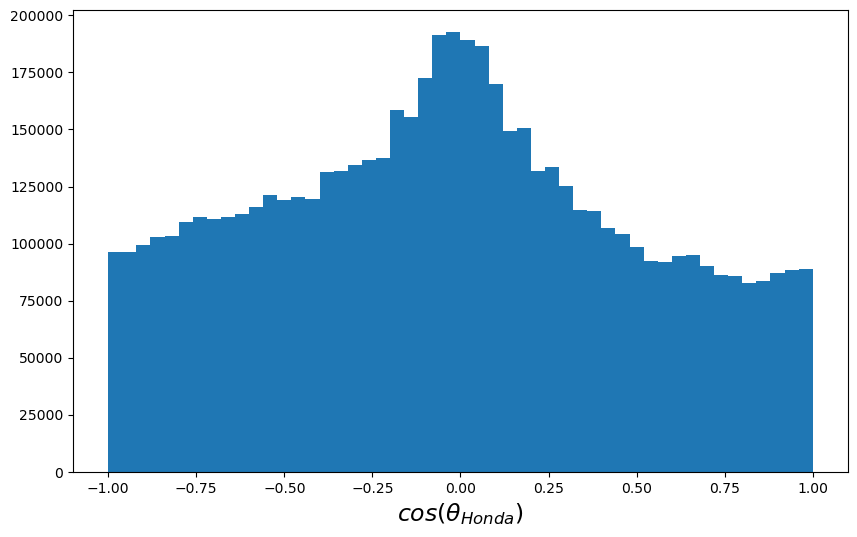

In [10]:
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
ax.hist(np.cos(plot_dirdetc_nu[:,1]), bins = 50, label = ' # Events')
ax.set_xlabel(r'$cos(\theta_{Honda})$', fontsize = 17)
#ax.set_xticks([0.0,0.78539,1.570,2.356,3.14159])
#ax.set_xticklabels([0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
#fig.colorbar(h[3], ax=ax)
#plt.title('Atmospherics_'+list_nuclearmodels[SAMPLE_INDEX])
plt.savefig('HondaFluxAng/DirectionDetector_Atmospherics_HondaCoordSys_cosTheta.pdf', format='pdf', dpi=300)
plt.show()

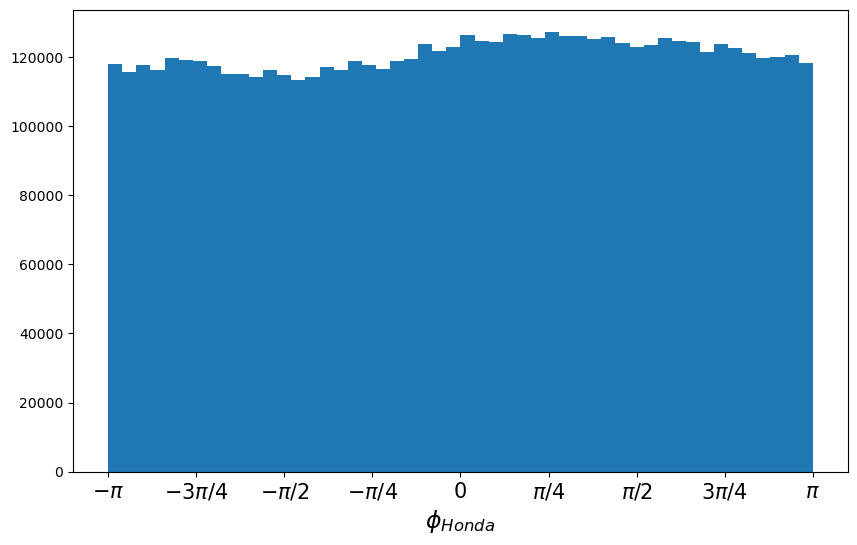

In [11]:
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
ax.hist(plot_dirdetc_nu[:,0], bins = 50, label = ' # Events')
ax.set_xlabel(r'$\phi_{Honda}$', fontsize = 17)
ax.set_xticks([-3.14559,-2.356,-1.570,-0.78539,0.0,0.78539,1.570,2.356,3.14159])
ax.set_xticklabels([r'$-\pi$',r'$ -3\pi / 4$', r'$-\pi / 2$', r'$-\pi / 4$',0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
#fig.colorbar(h[3], ax=ax)
#plt.title('Atmospherics_'+list_nuclearmodels[SAMPLE_INDEX])
plt.savefig('HondaFluxAng/DirectionDetector_Atmospherics_HondaCoordSys_Phi.pdf', format='pdf', dpi=300)
plt.show()

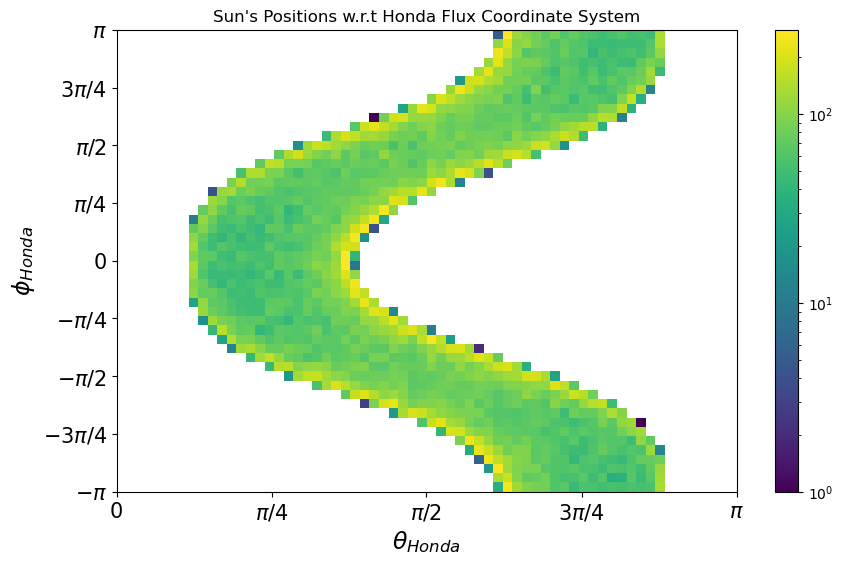

In [13]:
Sun_Positions = np.loadtxt('background_sun_pos.dat', delimiter='\t', usecols=(0,1,2))
PlotSunDirection = []
SunPosInHondaCoorS = [Inverse_FluxRotValues.dot(SunPos)  for SunPos in Sun_Positions] 
Phi_Theta_NuMom_Unit = [PlotSunDirection.append((math.atan2(SunPos[1], SunPos[0]), math.acos(SunPos[2]))) for SunPos in SunPosInHondaCoorS] 

fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
PlotSunDirection = np.array(PlotSunDirection)
h = ax.hist2d(PlotSunDirection[:,1],PlotSunDirection[:,0], bins = (50,50),  norm = colors.LogNorm(), label = ' # Events')
ax.set_xlabel(r'$\theta_{Honda}$', fontsize = 17)
ax.set_ylabel(r'$\phi_{Honda}$', fontsize = 17)
ax.set_xticks([0.0,0.78539,1.570,2.356,3.14159])
ax.set_xticklabels([0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
ax.set_yticks([-3.14559,-2.356,-1.570,-0.78539,0.0,0.78539,1.570,2.356,3.14159])
ax.set_yticklabels([r'$-\pi$',r'$ -3\pi / 4$', r'$-\pi / 2$', r'$-\pi / 4$',0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
fig.colorbar(h[3], ax=ax)
plt.title("Sun's Positions w.r.t Honda Flux Coordinate System")
plt.savefig('HondaFluxAng/SunPositions_HondaCoordSys.pdf', format='pdf', dpi=300)
plt.show()

In [14]:
def cosineAngle_wSphericalUnitVec(a,b):
    return np.sin(a[1])*np.sin(b[1])*np.cos(a[0]-b[0])+np.cos(a[1])*np.cos(b[1])

In [25]:
hist_cos_HondaCoordSys = []
for index, atmevt in enumerate(plot_dirdetc_nu):
    indices = np.random.randint(0, len(PlotSunDirection), size=1)
    # Use the sampled indices to select elements from the array
    sample_sunpos = PlotSunDirection[indices]
    #print(sample_sunpos[0])
    for sunpos in sample_sunpos:
        hist_cos_HondaCoordSys.append(cosineAngle_wSphericalUnitVec(atmevt,sample_sunpos[0]))

    if index > 200000:
        break
        

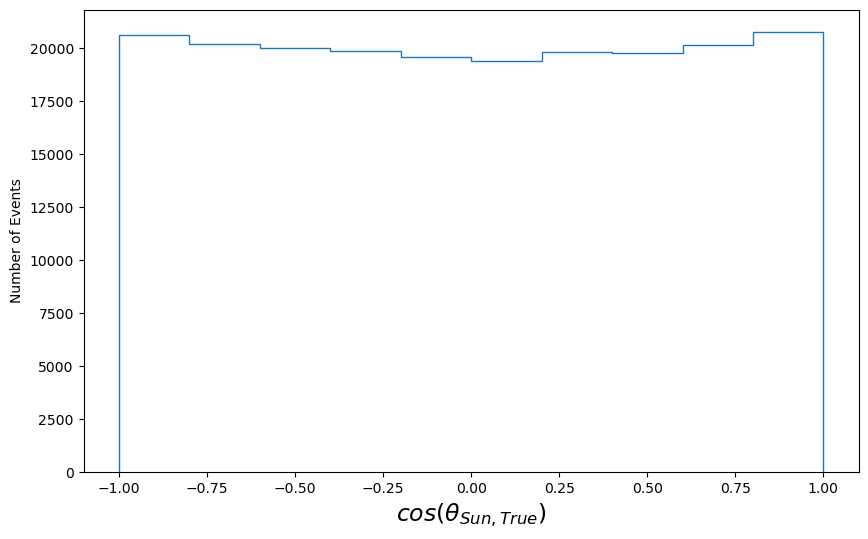

In [26]:
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
plt.hist(hist_cos_HondaCoordSys, bins = 10,histtype = 'step')
#plt.title(f'index number evt: {index}')
plt.ylabel('Number of Events')
plt.xlabel(r'$cos(\theta_{Sun, True})$',fontsize = 17)
plt.show()

### Simulates with Honda $\phi$ uniformally distributed ###

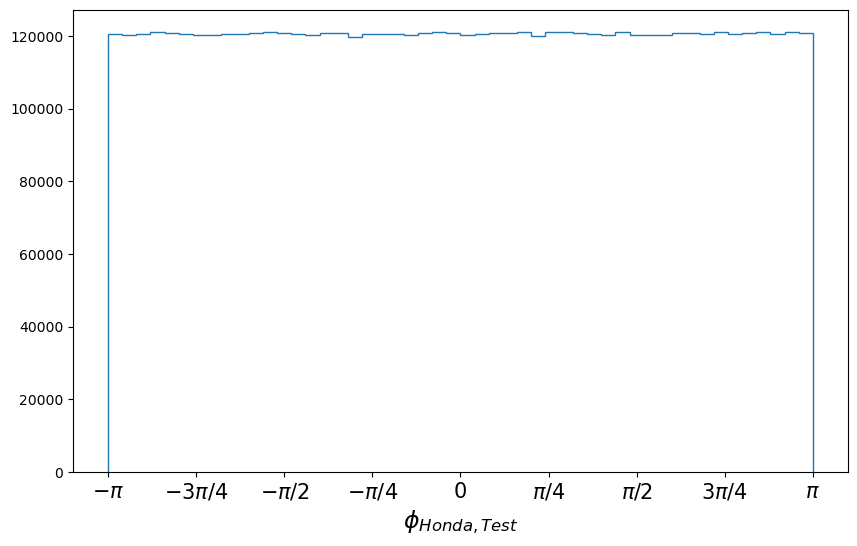

In [17]:
PhiHondaUnif = 2*np.pi*np.random.random_sample((plot_dirdetc_nu[:,0].size,))-np.pi
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
ax.hist(PhiHondaUnif, bins = 50,histtype = 'step')
#plt.title(f'index number evt: {index}')
ax.set_xticks([-3.14559,-2.356,-1.570,-0.78539,0.0,0.78539,1.570,2.356,3.14159])
ax.set_xticklabels([r'$-\pi$',r'$ -3\pi / 4$', r'$-\pi / 2$', r'$-\pi / 4$',0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
ax.set_xlabel(r'$\phi_{Honda, Test}$', fontsize = 17)
plt.show()

In [18]:
plot_dirdetc_nu_phiHondaIso = np.vstack((PhiHondaUnif, plot_dirdetc_nu[:,1])).T

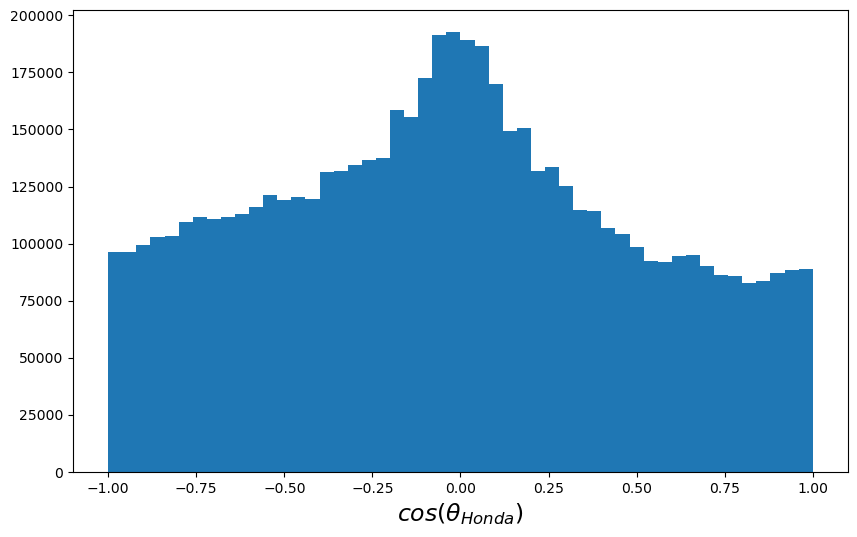

In [19]:
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
ax.hist(np.cos(plot_dirdetc_nu_phiHondaIso[:,1]), bins = 50, label = ' # Events')
ax.set_xlabel(r'$cos(\theta_{Honda})$', fontsize = 17)
#ax.set_xticks([0.0,0.78539,1.570,2.356,3.14159])
#ax.set_xticklabels([0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
#fig.colorbar(h[3], ax=ax)
#plt.title('Atmospherics_'+list_nuclearmodels[SAMPLE_INDEX])
plt.savefig('HondaFluxAng/DirectionDetector_Atmospherics_HondaCoordSys_CosTheta.pdf', format='pdf', dpi=300)
plt.show()

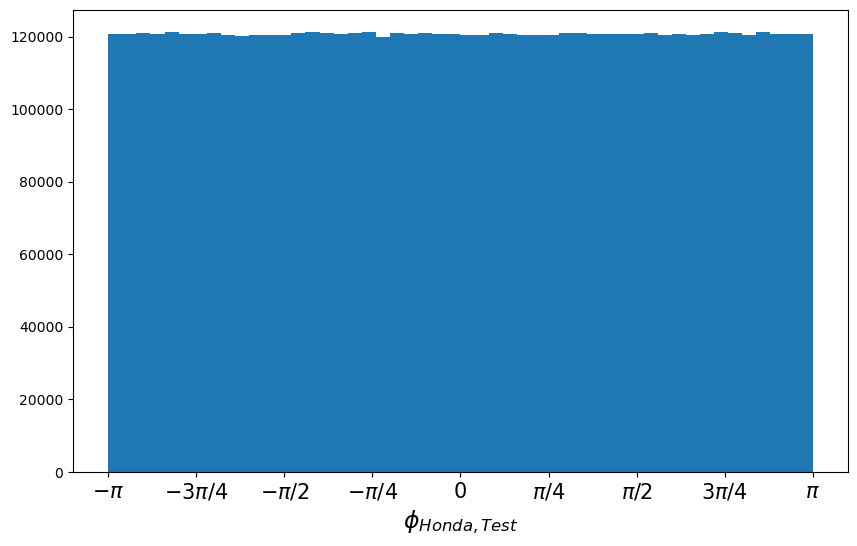

In [17]:
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
ax.hist(plot_dirdetc_nu_phiHondaIso[:,0], bins = 50, label = ' # Events')
ax.set_xlabel(r'$\phi_{Honda, Test}$', fontsize = 17)
ax.set_xticks([-3.14559,-2.356,-1.570,-0.78539,0.0,0.78539,1.570,2.356,3.14159])
ax.set_xticklabels([r'$-\pi$',r'$ -3\pi / 4$', r'$-\pi / 2$', r'$-\pi / 4$',0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
#fig.colorbar(h[3], ax=ax)
plt.show()

In [21]:
hist_cos_HondaCoordSys_PhiUnif = []
for index, atmevt in enumerate(plot_dirdetc_nu_phiHondaIso):
    indices = np.random.randint(0, len(PlotSunDirection), size=1)
    # Use the sampled indices to select elements from the array
    sample_sunpos = PlotSunDirection[indices]
    #print(sample_sunpos[0])
    for sunpos in sample_sunpos:
        hist_cos_HondaCoordSys_PhiUnif.append(cosineAngle_wSphericalUnitVec(atmevt,sample_sunpos[0]))

    if index > 200000:
        break

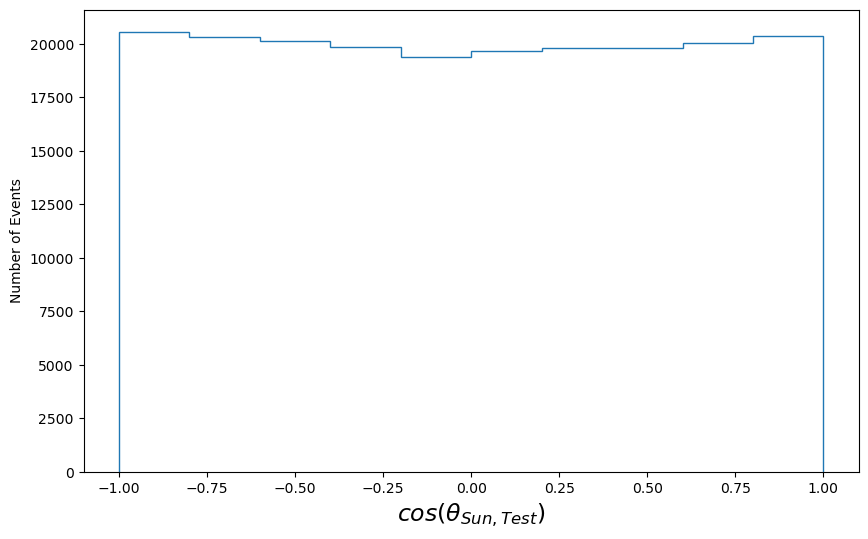

In [22]:
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
plt.hist(hist_cos_HondaCoordSys_PhiUnif, bins = 10,histtype = 'step')
#plt.title(f'index number evt: {index}')
plt.ylabel('Number of Events')
plt.xlabel(r'$cos(\theta_{Sun, Test})$',fontsize = 17)
plt.savefig('HondaFluxAng/Atmospherics_HondaCoordSys_CosTheta_wrtSun_IsoFakePhiHonda.pdf', format='pdf', dpi=300)
plt.show()

### Distributions of the θ and φ angle difference in the two cases (original Honda and symmetrised one).
#### Distribution of the $\theta$ is the same for both.

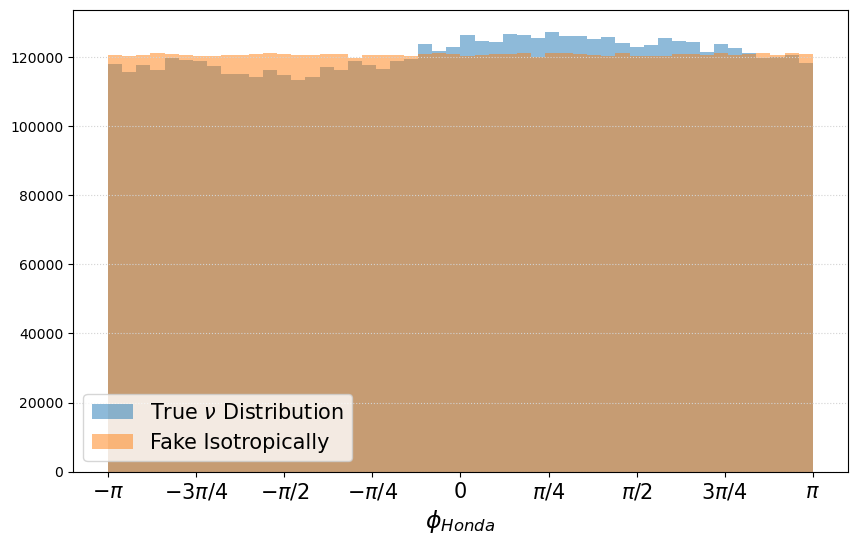

In [23]:
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
ax.hist(plot_dirdetc_nu[:,0], bins = 50,alpha = 0.5, label = r'True $\nu$ Distribution')
ax.hist(plot_dirdetc_nu_phiHondaIso[:,0], bins = 50,alpha = 0.5, label = 'Fake Isotropically')
ax.set_xlabel(r'$\phi_{Honda}$', fontsize = 17)
ax.set_xticks([-3.14559,-2.356,-1.570,-0.78539,0.0,0.78539,1.570,2.356,3.14159])
ax.set_xticklabels([r'$-\pi$',r'$ -3\pi / 4$', r'$-\pi / 2$', r'$-\pi / 4$',0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
plt.legend(loc= 'lower left', fontsize=15)
ax.grid(axis='y', color='lightgray', linestyle=':')
#fig.colorbar(h[3], ax=ax)
#plt.title('Atmospherics_'+list_nuclearmodels[SAMPLE_INDEX])
plt.savefig('HondaFluxAng/Comparision_Atmospherics_Phi_FakeAndReco.pdf', format='pdf', dpi=300)
plt.show()

### Superimpose the distribution of the sun/neutrino angle cosine in the two case in the same plot, to make it easier to estimate the difference (with horizontal grid, something like ax.grid(axis='y', color='lightgray', linestyle=':'))

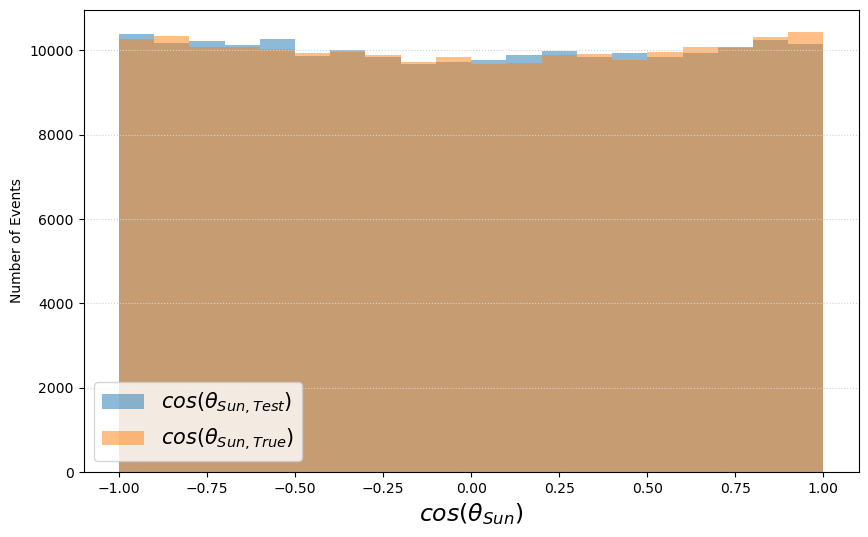

In [27]:
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
plt.hist(hist_cos_HondaCoordSys_PhiUnif, bins = 20, alpha=0.5, label= r'$cos(\theta_{Sun, Test})$')
plt.hist(hist_cos_HondaCoordSys, bins = 20, alpha=0.5, label = r'$cos(\theta_{Sun, True})$')
plt.legend(loc = 'lower left', fontsize = 15)
ax.grid(axis='y', color='lightgray', linestyle=':')
#plt.title(f'index number evt: {index}')
plt.ylabel('Number of Events')
plt.xlabel(r'$cos(\theta_{Sun})$',fontsize = 17)
plt.savefig('HondaFluxAng/Comparision_Atmospherics_CosSun_wHondaPhi_FakeAndReco.pdf', format='pdf', dpi=300)
plt.show()